In [ ]:
!pip install numpy pandas matplotlib seaborn plotly folium geopandas

In [3]:
import numpy as np          # Numerical operations
import pandas as pd         # Data manipulation
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns       # Statistical visualization
import plotly.express as px # Interactive visualization
import folium               # Maps
import geopandas as gpd     # Geospatial data handling

# Preparing the Dataset

In [7]:
# Keeping the columns we need
columns_to_keep = ["PUFREG", "PUFURB2015", "PUFC04_SEX", "PUFC05_AGE",
                   "PUFC06_MSTAT", "PUFC07_GRADE", "PUFC16_PKB", "PUFC25_PBASIC"]

#Loading the dataframes needed with all the relevant stuff
Jan2023 = pd.read_csv("LFS_January_2023.CSV", usecols=columns_to_keep)
Apr2023 = pd.read_csv("LFS_April_2023.CSV", usecols=columns_to_keep)
Jul2023 = pd.read_csv("LFS_July_2023.CSV", usecols=columns_to_keep)

# Merge the datasets
LFS_merged = pd.concat([Jan2023, Apr2023, Jul2023], ignore_index=True)


# Converting region to string
LFS_merged['PUFREG'] = LFS_merged['PUFREG'].astype(str)

# Converting basic pay to numeric
LFS_merged['PUFC25_PBASIC'] = pd.to_numeric(LFS_merged['PUFC25_PBASIC'], errors='coerce')


In [1]:
#assigning words to urban and rural
urban_rural = {1: 'Urban', 2: 'Rural'}
LFS_merged['PUFURB2015'] = LFS_merged['PUFURB2015'].map(urban_rural)

# Average basic pay per day across regions
region_avg = LFS_merged.groupby('PUFREG')['PUFC25_PBASIC'].mean().reset_index()

# Difference between Urban and Rural basic pay (for curiosity)
urban_rural_avg = LFS_merged.groupby('PUFURB2015')['PUFC25_PBASIC'].mean()
urban_rural_diff = urban_rural_avg['Urban'] - urban_rural_avg['Rural']

print("Average Basic Pay by Region:\n", region_avg)
print("\nDifference between Urban and Rural:", urban_rural_diff)

plt.figure(figsize=(10, 6))

# Plotting everything
plt.bar(region_avg['PUFREG'], region_avg['PUFC25_PBASIC'], color='skyblue')

plt.title("Average Basic Pay Per Region")
plt.xlabel("Region")
plt.ylabel("Average Basic Pay")
plt.xticks(rotation=45)  # Rotate labels for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

NameError: name 'LFS_merged' is not defined

# With a Map

In [9]:
shapefile = gpd.read_file("phl_admbnda_adm1_psa_namria_20231106.shp")

In [11]:
#renaming the region var to be consistent with the shape file
name_mapping = {
    '13': 'National Capital Region (NCR)',
    '14': 'Cordillera Administrative Region (CAR)',
    '1': 'Region I (Ilocos Region)',
    '2': 'Region II (Cagayan Valley)',
    '3': 'Region III (Central Luzon)',
    '4': 'Region IV-A (Calabarzon)',
    '17': 'Mimaropa Region',
    '5': 'Region V (Bicol Region)',
    '6': 'Region VI (Western Visayas)',
    '7': 'Region VII (Central Visayas)',
    '8': 'Region VIII (Eastern Visayas)',
    '9': 'Region IX (Zamboanga Peninsula)',
    '10': 'Region X (Northern Mindanao)',
    '11': 'Region XI (Davao Region)',
    '12': 'Region XII (Soccsksargen)',
    '16': 'Region XIII (Caraga)',
    '15': 'Bangsamoro Autonomous Region In Muslim Mindanao (BARMM)',
}

LFS_merged['PUFREG'] = LFS_merged['PUFREG'].replace(name_mapping)


In [13]:
#assigning geometry to each row
shapefile = shapefile[['ADM1_EN', 'geometry']]
LFS_merged = LFS_merged.merge(shapefile, left_on="PUFREG", right_on="ADM1_EN", how="left")
#making the dataset Pandas to Geospatial something
LFS_merged = gpd.GeoDataFrame(LFS_merged, geometry="geometry")

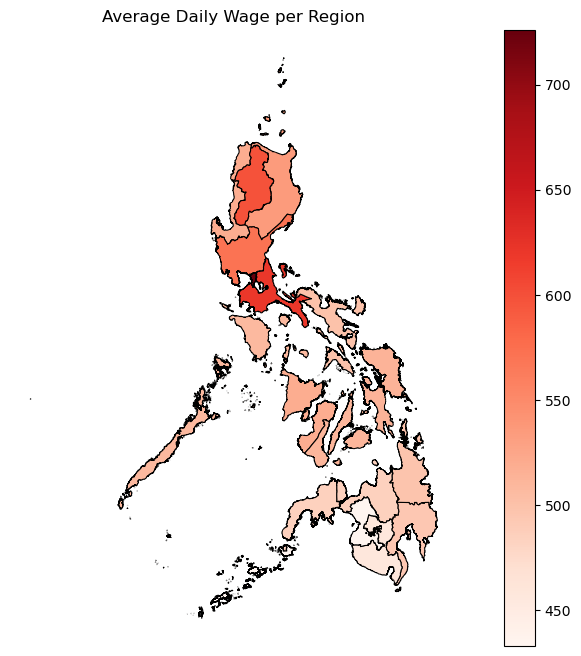

In [17]:
region_avg = LFS_merged.groupby("PUFREG", as_index=False)["PUFC25_PBASIC"].mean()

# Merge the shapefile with the wage data
LFS_merged = shapefile.merge(region_avg, left_on="ADM1_EN", right_on="PUFREG", how="left")

# Convert to GeoDataFrame
LFS_merged = gpd.GeoDataFrame(LFS_merged, geometry="geometry")

# Plot the choropleth
fig, ax = plt.subplots(figsize=(12, 8))
LFS_merged.plot(column="PUFC25_PBASIC", cmap="Reds", linewidth=0.8, edgecolor="black", legend=True, ax=ax)

plt.title("Average Daily Wage per Region")
plt.axis("off")
plt.show()

In [ ]:
print("LFS_merged unique regions:", LFS_merged["PUFREG"].unique())
print("Shapefile unique regions:", shapefile["ADM1_EN"].unique())
